Epoch 1, Training loss 217.9230, Validation loss 95.3390
Epoch 1000, Training loss 2.3065, Validation loss 8.9994
Epoch 2000, Training loss 1.9141, Validation loss 7.9130
Epoch 3000, Training loss 1.0496, Validation loss 8.6561
Epoch 4000, Training loss 0.9256, Validation loss 9.1599
Epoch 5000, Training loss 0.9146, Validation loss 9.2096
output tensor([[16.1262],
        [-0.2697]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [ 3.]])
hidden tensor([[-5.3535e+00],
        [-2.6346e-03],
        [ 5.4024e+00],
        [ 6.2302e-02],
        [-5.1517e-01],
        [-2.3847e-02],
        [ 1.1954e+00],
        [ 1.6197e-03],
        [ 6.0340e-04],
        [-3.6114e+00],
        [ 4.7680e+00],
        [ 9.6344e-01],
        [-5.0699e-03],
        [-5.5381e+00]])


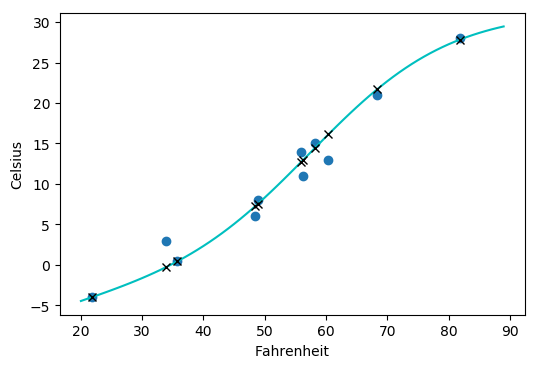

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

#-----数据处理-----
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

#随机获取训练集与验证集索引
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

#train_indices, val_indices
#(tensor([ 0,  5,  8,  1, 10,  7,  9,  4,  6]), tensor([3, 2])) #结果随机

#根据索引划分训练集与验证集
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

#将t_u进行规范化
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 *t_u_val

#-----定义网络-----
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 14)
        # 去掉了nn.Tanh()
        self.output_linear = nn.Linear(14, 1)

    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t) # nn.Tanh对应的函数
        output_t = self.output_linear(activated_t)
        return output_t

#-----定义训练器-----
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch %d, Training loss %.4f, Validation loss %.4f' % (
                    epoch, float(loss_train), float(loss_val)))
#实例化网络
func_model = SubclassFunctionalModel()
optimizer = optim.SGD(func_model.parameters(), lr=1e-3)

#开始训练
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = func_model,
    loss_fn = nn.MSELoss(), # 不再使用自己定义的loss
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

#验证效果
print('output', func_model(t_un_val))
print('answer', t_c_val)
print('hidden', func_model.hidden_linear.weight.grad)

#绘制图像
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), func_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), func_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()


